In [1]:
# We will need some functionality 
from typing import List 

# and from math related libraries
import numpy as np
import qutip as qt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.circuit import Parameter,ParameterVector
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator
import pylab

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, ADAM
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X,Y,Z

In [2]:
def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[List[int]]],
                              h_coeffs: List[List[float]]) -> np.ndarray:
    #Creates a global Hamiltonian consisting of a sum of one (g1 * Z^i.Z^j + g2 * Z^i.Z^j.Z^k) term per device connection.

    #Args:
    #    num_qubits (int): number of qubits of the Hamiltonian
    #    connectivity (List[List[int]]): connectivity of the device
    #    h_coeffs (List[float]): list of coefficients of each ZZ term

    #Returns:
    #    np.ndarray: tensored Hamiltonian
    
    
    dim = 2 ** num_qubits
    num_connections1 = len(connectivity[0])
    num_connections2 = len(connectivity[1])
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections1):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[0][c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[0][c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[0][c] * np.array(qt.tensor(ops_to_tensor))
    for c in range(num_connections2):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[1][c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[1][c][1]] = qt.sigmaz()
        ops_to_tensor[connectivity[1][c][2]] = qt.sigmaz()
        zz_hamiltonian += float(h_coeffs[1][c]) * np.array(qt.tensor(ops_to_tensor))
    return zz_hamiltonian

In [ ]:
""" def create_zz_hamiltonian(num_qubits: int, connectivity: List[List[List[int]]],
                              h_coeffs: List[List[float]]) -> np.ndarray:
    Creates a global Hamiltonian consisting of a sum of one (g1 * Z^i.Z^j + g2 * Z^i.Z^j.Z^k) term per device connection.

    Args:
        num_qubits (int): number of qubits of the Hamiltonian
        connectivity (List[List[int]]): connectivity of the device
        h_coeffs (List[float]): list of coefficients of each ZZ term

    Returns:
        np.ndarray: tensored Hamiltonian
    
    
    dim = 2 ** num_qubits
    num_connections1 = len(connectivity[0])
    num_connections2 = len(connectivity[1])
    num_connections3 = len(connectivity[2])
    zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

    # create a matrix that is the sum of ZZ operators on all connected qubits,
    # tensored with the identity
    for c in range(num_connections1):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[0][c][0]] = qt.sigmax()
        ops_to_tensor[connectivity[0][c][1]] = qt.sigmax()
        zz_hamiltonian += h_coeffs[0][c] * np.array(qt.tensor(ops_to_tensor))
    for c in range(num_connections2):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[1][c][0]] = qt.sigmay()
        ops_to_tensor[connectivity[1][c][1]] = qt.sigmay()
        #ops_to_tensor[connectivity[1][c][2]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[1][c] * np.array(qt.tensor(ops_to_tensor))
    for c in range(num_connections3):
        ops_to_tensor = [qt.identity(2)] * num_qubits
        ops_to_tensor[connectivity[0][c][0]] = qt.sigmaz()
        ops_to_tensor[connectivity[0][c][1]] = qt.sigmaz()
        zz_hamiltonian += h_coeffs[2][c] * np.array(qt.tensor(ops_to_tensor))
    return zz_hamiltonian """

In [3]:
from numbers import Number

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeffs, label=None):
        if isinstance(time, Number) and time != np.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        self.h_coeffs = h_coeffs
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeffs], label=label)

    def __array__(self, dtype=None):
        #Return matrix for the unitary.
        # pylint: disable=unused-argument
        import scipy.linalg

        #try:
        return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        #except TypeError as ex:
        #    raise TypeError(
        #        "Unable to generate Unitary matrix for "
        #        "unbound t parameter {}".format(self.params[1])
        #    ) from ex

    def _define(self):
        #Calculate a subcircuit that implements this unitary.
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections1 = len(self.connectivity[0])
        num_connections2 = len(self.connectivity[1])
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

        for c in range(num_connections1):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[0][c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[0][c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3][0][c]) * np.array(qt.tensor(ops_to_tensor)) #+= 
        for c in range(num_connections2):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[1][c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[1][c][1]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[1][c][2]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3][1][c]) * np.array(qt.tensor(ops_to_tensor))
        return zz_hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeffs, qubits, label=None):
    #Apply hamiltonian evolution to qubits.
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits =len(qubits), connectivity=connectivity, h_coeffs=h_coeffs, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian

In [ ]:
""" from numbers import Number

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeffs, label=None):
        if isinstance(time, Number) and time != np.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        self.h_coeffs = h_coeffs
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeffs], label=label)

    def __array__(self, dtype=None):
        #Return matrix for the unitary.
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        #Calculate a subcircuit that implements this unitary.
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections1 = len(self.connectivity[0])
        num_connections2 = len(self.connectivity[1])
        num_connections3 = len(self.connectivity[2])
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)

        for c in range(num_connections1):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[0][c][0]] = qt.sigmax()
            ops_to_tensor[self.connectivity[0][c][1]] = qt.sigmax()
            zz_hamiltonian += float(self.params[3][0][c]) * np.array(qt.tensor(ops_to_tensor)) #+= 
        for c in range(num_connections2):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[1][c][0]] = qt.sigmay()
            ops_to_tensor[self.connectivity[1][c][1]] = qt.sigmay()
            #ops_to_tensor[self.connectivity[1][c][2]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3][1][c]) * np.array(qt.tensor(ops_to_tensor))
        for c in range(num_connections3):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[2][c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[2][c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3][2][c]) * np.array(qt.tensor(ops_to_tensor)) 
        return zz_hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeffs, qubits, label=None):
    #Apply hamiltonian evolution to qubits.
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits =len(qubits), connectivity=connectivity, h_coeffs=h_coeffs, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian """

In [4]:
# Returns the xxx Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3(num_qubits):
    # FILL YOUR CODE IN HERE
    H = 0
    #num_qubits = 3
    for i in range(num_qubits-1):
        H += (I^(num_qubits-i-2))^X^X^(I^i)
    for i in range(num_qubits-1):
        H += (I^(num_qubits-i-2))^Y^Y^(I^i)
    for i in range(num_qubits-1):
        H += (I^(num_qubits-i-2))^Z^Z^(I^i)
    # Return Hamiltonian
    return H

In [5]:
H_heis = H_heis3(5)
print(f'Number of qubits: {H_heis.num_qubits}')
num_qubits = H_heis.num_qubits

Number of qubits: 5


In [ ]:
#t = Parameter('time')
#enforcing no. of qubits less than 
#num_qubits = H_heis.num_qubits
#letterg1 = list(map(chr, range(97, 97+num_qubits)))
#letterg2 = list(map(chr, range(97+num_qubits,97+num_qubits+num_qubits-1)))
#g1 = [Parameter(x) for x in letterg1]
#g2 = [Parameter(x) for x in letterg2]
#hamiltonian = create_zz_hamiltonian(num_qubits, [[[0,1],[1,2],[2,3],[3,4],[4,1]],[[0,1,2],[1,2,3],[2,3,4],[3,4,0],[4,0,1]]], [[-1.,-1.,-1.,-1.,-1.],[-1.,-1.,-1.,-1.,-1.]])
#analog_block = HamiltonianGate(data=hamiltonian, time=t)

In [6]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H_heis)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -7.71155


In [11]:
seed = 69
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [8]:
# First we need to define at least one variational parameter
#theta = Parameter('a')
#psi = Parameter('b')

no_qubits = H_heis.num_qubits
nlayers = 2
connectivity = [[[0, 1],[1,2],[2,3],[3,4]],[]]
h_coeffs = [[1.,1.,1.,1.],[]]

## Using Digital Approach

In [9]:

# Create a quantum circuit that is used for the ansatz
qr2 = QuantumRegister(H_heis.num_qubits)
ansatz2 = QuantumCircuit(qr2)
#hmm = TwoLocal(num_qubits=H_heis.num_qubits,rotation_blocks=['rx','ry','rz'],entanglement_blocks=analog_block,entanglement='full',reps=nlayers,insert_barriers=True)
#ansatz +=hmm
for i in range(nlayers):
    a = ParameterVector(3*i,no_qubits)
    for j in range(no_qubits-1):
        ansatz2.rxx(a[j],j,j+1)
    b = ParameterVector(3*i+1,no_qubits)
    for j in range(no_qubits):
        ansatz2.rx(b[j],j)
    c = ParameterVector(3*i+2,no_qubits)
    for j in range(no_qubits):
        ansatz2.rz(c[j],j)
""" for i in range(nlayers):
    a = ParameterVector(5*i,no_qubits)
    for j in range(no_qubits):
        ansatz.rx(a[j],j)
    b = ParameterVector(5*i+1,1)
    ansatz.custom_hamiltonian(connectivity=connectivity,h_coeffs=h_coeffs,time=b[0],qubits=[qr[i] for i in range(no_qubits)],label='analog_block')
    c = ParameterVector(5*i+2,no_qubits)
    for j in range(no_qubits):
        ansatz.ry(c[j],j)
    d = ParameterVector(5*i+3,1)
    ansatz.custom_hamiltonian(connectivity=connectivity,h_coeffs=h_coeffs,time=d[0],qubits=[qr[i] for i in range(no_qubits)],label='analog_block')
    e = ParameterVector(5*i+4,no_qubits)
    for j in range(no_qubits):
        ansatz.rz(e[j],j) """
""" timeparas = list(map(chr, range(97, 97+2*nlayers)))
for i in range(nlayers):
    a = ParameterVector(7*i,no_qubits)
    for j in range(no_qubits):
        ansatz.rx(a[j],j)
    d = [ParameterVector(7*i+1,len(connectivity[0])),ParameterVector(7*i+2,len(connectivity[1]))]
    e = Parameter(timeparas[2*i])
    ansatz.custom_hamiltonian(connectivity=connectivity,h_coeffs=d,time=e,qubits=[qr[i] for i in range(no_qubits)],label='analog_block')
    b = ParameterVector(7*i+3,no_qubits)
    for j in range(no_qubits):
        ansatz.ry(b[j],j)
    f = [ParameterVector(7*i+4,len(connectivity[0])),ParameterVector(7*i+5,len(connectivity[1]))]
    g = Parameter(timeparas[2*i+1])
    ansatz.custom_hamiltonian(connectivity=connectivity,h_coeffs=f,time=g,qubits=[qr[i] for i in range(no_qubits)],label='analog_block')
    c = ParameterVector(7*i+6,no_qubits)
    for j in range(no_qubits):
        ansatz.rz(c[j],j) """
""" # add some single-qubit gates
for i in range(no_qubits-1):
    if i % 2 == 0:
        ansatz.rx(psi, i)

ansatz.rz(theta, range(no_qubits))
    
# add a chain of CNOTs (multi-qubit gates)
for i in range(no_qubits-1):
    ansatz.cx(i, i+1)
ansatz.cx(no_qubits-1,0)
ansatz.barrier() """
""" t = Parameter('time')
letterg1 = list(map(chr, range(97, 97+num_qubits)))
letterg2 = list(map(chr, range(97+num_qubits,97+num_qubits+num_qubits-1)))
g1 = [Parameter(x) for x in letterg1]
g2 = [Parameter(x) for x in letterg2]
ansatz.custom_hamiltonian(connectivity=[[[0, 1],[1,2],[2,3],[3,4],[4,1]],[[0,1,2],[1,2,3],[2,3,4],[4,1,2]]], h_coeffs=[g1,g2], time=t, qubits=[qr[i] for i in range(no_qubits)], label='analog block') """
    

# If you have prepared a state before, you can combine it with your ansatz
# ansatz.compose(prepared_state, front=True, inplace=True)

#print(ansatz.decompose().draw())
ansatz2.draw()

┌────────────┐ ┌──────────┐  ┌──────────┐               ┌────────────┐»
q0_0: ┤0           ├─┤ Rx(1[0]) ├──┤ Rz(2[0]) ├───────────────┤0           ├»
      │  Rxx(0[0]) │┌┴──────────┴┐ ├──────────┤  ┌──────────┐ │  Rxx(3[0]) │»
q0_1: ┤1           ├┤0           ├─┤ Rx(1[1]) ├──┤ Rz(2[1]) ├─┤1           ├»
      └────────────┘│  Rxx(0[1]) │┌┴──────────┴┐ ├──────────┤ └┬──────────┬┘»
q0_2: ──────────────┤1           ├┤0           ├─┤ Rx(1[2]) ├──┤ Rz(2[2]) ├─»
                    └────────────┘│  Rxx(0[2]) │┌┴──────────┴┐ ├──────────┤ »
q0_3: ────────────────────────────┤1           ├┤0           ├─┤ Rx(1[3]) ├─»
                                  └────────────┘│  Rxx(0[3]) │ ├──────────┤ »
q0_4: ──────────────────────────────────────────┤1           ├─┤ Rx(1[4]) ├─»
                                                └────────────┘ └──────────┘ »
«       ┌──────────┐  ┌──────────┐                                       
«q0_0: ─┤ Rx(4[0]) ├──┤ Rz(5[0]) ├───────────────────────────────────────
«      ┌┴──────────┴┐ ├──────────┤  ┌──────────┐                         
«q0_1: ┤0           ├─┤ Rx(4[1]) ├──┤ Rz(5[1]) ├─────────────────────────
«      │  Rxx(3[1]) │┌┴──────────┴┐ ├──────────┤ ┌──────────┐            
«q0_2: ┤1           ├┤0           ├─┤ Rx(4[2]) ├─┤ Rz(5[2]) ├────────────
«      └┬──────────┬┘│  Rxx(3[2]) │┌┴──────────┴┐├──────────┤┌──────────┐
«q0_3: ─┤ Rz(2[3]) ├─┤1           ├┤0           ├┤ Rx(4[3]) ├┤ Rz(5[3]) ├
«       ├──────────┤ └────────────┘│  Rxx(3[3]) │├──────────┤├──────────┤
«q0_4: ─┤ Rz(2[4]) ├───────────────┤1           ├┤ Rx(4[4]) ├┤ Rz(5[4]) ├
«       └──────────┘               └────────────┘└──────────┘└──────────┘

In [12]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz2, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H_heis)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -7.20312
Delta from reference energy value is 0.50842


Text(0.5, 1.0, 'Convergence with no noise (Digital)')

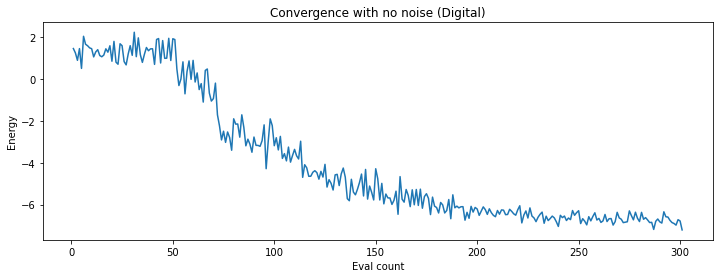

In [13]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise (Digital)')

## Using DAQC

In [14]:
countsa = []
valuesa = []
def store_intermediate_resulta(eval_count, parameters, mean, std):
    countsa.append(eval_count)
    valuesa.append(mean)
qr = QuantumRegister(no_qubits)
ansatz = QuantumCircuit(qr)
tparams = []
for i in range(nlayers):
    #a = ParameterVector(3*i,no_qubits)
    #for j in range(no_qubits):
    #    ansatz.rx(a[j],j)
    tparams.append(ParameterVector(f"p{3*i}",1))
    #huh = ParameterVector(4*i+1,4)
    #hh = [[huh[i] for i in range(len(huh))],[]]
    ansatz.custom_hamiltonian(connectivity=connectivity,h_coeffs=h_coeffs,time=tparams[-1][0],qubits=[qr[i] for i in range(no_qubits)],label='analog_block')
    c = ParameterVector(f"p{3*i+1}",no_qubits)
    for j in range(no_qubits):
        ansatz.rx(c[j],j)
    #d = ParameterVector(5*i+3,1)
    #ansatz.custom_hamiltonian(connectivity=connectivity,h_coeffs=h_coeffs,time=d[0],qubits=[qr[i] for i in range(no_qubits)],label='analog_block')
    e = ParameterVector(f"p{3*i+2}",no_qubits)
    for j in range(no_qubits):
        ansatz.rz(e[j],j)
print(ansatz.draw())
""" t = Parameter('t')
#num_qubits = H_heis.num_qubits
hamiltonian = create_zz_hamiltonian(num_qubits, [[[0, 1],[1,2]],[]], [[1.,1.],[]]) 
analog_block = HamiltonianGate(data=hamiltonian, time=t)
ansatz = QuantumCircuit(H_heis.num_qubits)
hmm = TwoLocal(num_qubits=H_heis.num_qubits,rotation_blocks=['rx','rz'],entanglement_blocks=analog_block,reps=nlayers,insert_barriers=True)
ansatz.compose(hmm,inplace=True)
print(ansatz.decompose().draw())
print(ansatz.parameters) """

       »
q93_0: »
       »
q93_1: »
       »
q93_2: »
       »
q93_3: »
       »
q93_4: »
       »
«       ┌──────────────────────────────────────────────────────────────────────────────────────────┐»
«q93_0: ┤0                                                                                         ├»
«       │                                                                                          │»
«q93_1: ┤1                                                                                         ├»
«       │                                                                                          │»
«q93_2: ┤2 analog_block(p0[0],5,[[[0, 1], [1, 2], [2, 3], [3, 4]], []],[[1.0, 1.0, 1.0, 1.0], []]) ├»
«       │                                                                                          │»
«q93_3: ┤3                                                                                         ├»
«       │                                                                            

" t = Parameter('t')\n#num_qubits = H_heis.num_qubits\nhamiltonian = create_zz_hamiltonian(num_qubits, [[[0, 1],[1,2]],[]], [[1.,1.],[]]) \nanalog_block = HamiltonianGate(data=hamiltonian, time=t)\nansatz = QuantumCircuit(H_heis.num_qubits)\nhmm = TwoLocal(num_qubits=H_heis.num_qubits,rotation_blocks=['rx','rz'],entanglement_blocks=analog_block,reps=nlayers,insert_barriers=True)\nansatz.compose(hmm,inplace=True)\nprint(ansatz.decompose().draw())\nprint(ansatz.parameters) "

In [15]:
ansatz.parameters

ParameterView([ParameterVectorElement(p0[0]), ParameterVectorElement(p1[0]), ParameterVectorElement(p1[1]), ParameterVectorElement(p1[2]), ParameterVectorElement(p1[3]), ParameterVectorElement(p1[4]), ParameterVectorElement(p2[0]), ParameterVectorElement(p2[1]), ParameterVectorElement(p2[2]), ParameterVectorElement(p2[3]), ParameterVectorElement(p2[4]), ParameterVectorElement(p3[0]), ParameterVectorElement(p4[0]), ParameterVectorElement(p4[1]), ParameterVectorElement(p4[2]), ParameterVectorElement(p4[3]), ParameterVectorElement(p4[4]), ParameterVectorElement(p5[0]), ParameterVectorElement(p5[1]), ParameterVectorElement(p5[2]), ParameterVectorElement(p5[3]), ParameterVectorElement(p5[4])])

In [17]:
spsa = SPSA(maxiter=iterations)
vqe = VQE(ansatz, optimizer=spsa, callback=store_intermediate_resulta, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H_heis)
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (no noise): -6.49805
Delta from reference energy value is 1.21350


In [37]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 250,
    'eigenstate': {   '00010': 0.03125,
                      '01000': 0.04419417382415922,
                      '01001': 0.4341388746703064,
                      '01010': 0.722138750518209,
                      '01011': 0.05412658773652741,
                      '01101': 0.03125,
                      '01110': 0.10364452469860624,
                      '10000': 0.03125,
                      '10001': 0.27775607554111215,
                      '10010': 0.426193178030808,
                      '10110': 0.0625,
                      '11001': 0.03125,
                      '11010': 0.08838834764831845},
    'eigenvalue': (-6.498046875+0j),
    'optimal_parameters': {   ParameterVectorElement(p0[0]): 3.0268404529401454,
                              ParameterVectorElement(p1[0]): -1.68910428334289,
                              ParameterVectorElement(p1[1]): 4.223118396570804,
                              ParameterVe

In [38]:
init_pt = result.optimal_point
init_pt = list(init_pt)
nansatz = ansatz.copy()
for i in range(nlayers):
    nansatz = nansatz.bind_parameters({tparams[i]:[init_pt[(2*no_qubits)*i]]})
    init_pt.pop((2*no_qubits)*i)
#bp
print(nansatz.draw())
print(len(init_pt))

       »
q93_0: »
       »
q93_1: »
       »
q93_2: »
       »
q93_3: »
       »
q93_4: »
       »
«       ┌─────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q93_0: ┤0                                                                                                    ├»
«       │                                                                                                     │»
«q93_1: ┤1                                                                                                    ├»
«       │                                                                                                     │»
«q93_2: ┤2 analog_block(3.02684045294015,5,[[[0, 1], [1, 2], [2, 3], [3, 4]], []],[[1.0, 1.0, 1.0, 1.0], []]) ├»
«       │                                                                                                     │»
«q93_3: ┤3                                                                                                    

Text(0.5, 1.0, 'Convergence with no noise (DAQC)')

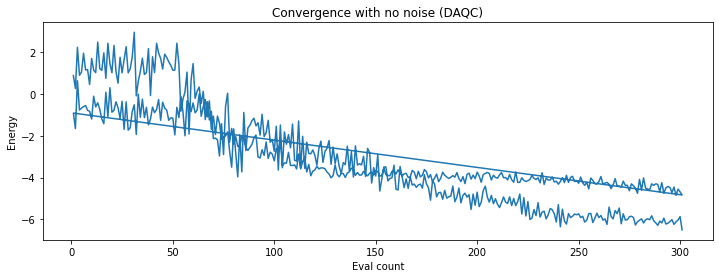

In [39]:
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(countsa, valuesa)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence with no noise (DAQC)')

## Performance *with* noise

In [49]:
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()

algorithm_globals.random_seed = seed
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,)

def store_intermediate_result1(eval_count, parameters, mean, std):
    counts1.append(eval_count)
    values1.append(mean)
#print(ansatz.decompose().draw())
#var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
#ansatz.bind_parameters({'\u03b8[6]':6.017476377491061,'\u03b8[13]':6.017476377491061})
spsa = SPSA(maxiter=iterations)
vqe = VQE(nansatz, optimizer=spsa,initial_point=init_pt, callback=store_intermediate_result1, quantum_instance=qi)
result1 = vqe.compute_minimum_eigenvalue(operator=H_heis)
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}')

NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['sx', 'id', 'cx', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]

VQE on Aer qasm simulator (with noise): 

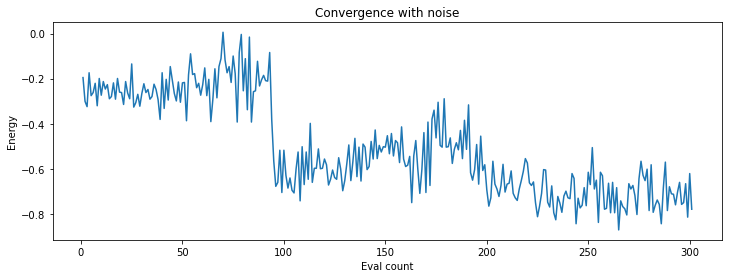

In [50]:
if counts1 or values1:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts1, values1)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise')

## Performance *with* noise and measurement error mitigation

In [46]:
from qiskit.utils.mitigation import CompleteMeasFitter

counts2 = []
values2 = []
if noise_model is not None:
    algorithm_globals.random_seed = seed
    qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         coupling_map=coupling_map, noise_model=noise_model, 
                         measurement_error_mitigation_cls=CompleteMeasFitter, 
                         cals_matrix_refresh_period=30)

    def store_intermediate_result2(eval_count, parameters, mean, std):
        counts2.append(eval_count)
        values2.append(mean)

    #ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
    spsa = SPSA(maxiter=iterations)
    vqe = VQE(nansatz, optimizer=spsa,initial_point=init_pt,callback=store_intermediate_result2, quantum_instance=qi)
    result2 = vqe.compute_minimum_eigenvalue(operator=H_heis)
    print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')
    print(f'Delta from reference energy value is {(result2.eigenvalue.real - ref_value):.5f}')

VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.07617
Delta from reference energy value is 6.63537


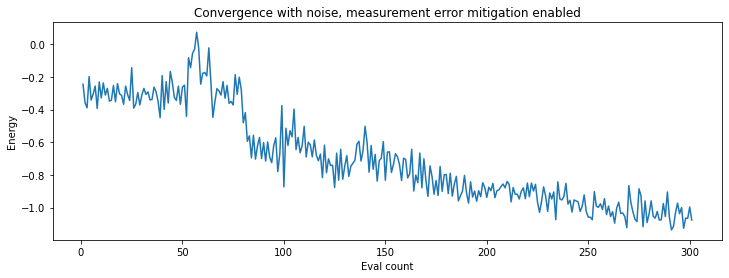

In [47]:
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2, values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise, measurement error mitigation enabled')

Lets bring the results together here for a summary. 

We produced a reference value using a classical algorithm and then proceeded to run VQE on a qasm simulator. While the simulation is ideal (no noise) there is so called shot-noise due to sampling - increasing the number of shots reduces this as more and more samples are taken, but shots was left at the default of 1024 and we see a small effect in the outcome. 

Then we added noise using a model taken off a real device and can see the result is affected. Finally we added measurement noise mitigation which adjusts the results in an attempt to alleviate the affect of noise in the classical equipment measuring the qubits.

In [51]:
print(f'Reference value: {ref_value:.5f}')
print(f'VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}')
print(f'VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}')

Reference value: -7.71155
VQE on Aer qasm simulator (no noise): -6.49805
VQE on Aer qasm simulator (with noise): -0.77930
VQE on Aer qasm simulator (with noise and measurement error mitigation): -1.07617
